# Validate DINOv3 CHM with airborne lidar grids (LVIS): 
## Step2: `read indiv CSVs`, `apply classifiers`, & `concat large data frame` and `save`
## - this is done on the `dm_10m` version of the results

Note: plots here here have been replaced by: `validate_chm_plots_dinov3_R.ipynb`

Paul Montesano  
Jan 2026

In [1]:
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import folium

import contextily as ctx

import os
import sys
import glob
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import *

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib
import maplib

# # This is a private repo
# sys.path.append('/home/pmontesa/code/dgtools')
# from dgtools.lib import dglib

# 
sys.path.append('/home/pmontesa/code/above-shrubs')
import notebooks.predlib

import random
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotnine
from plotnine import *

import sklearn.metrics as metrics
from scipy import stats


In [2]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [3]:
from multiprocessing import Pool
from functools import partial

### Paths from Sept-Dec 2025 work

In [4]:
# NOTE - we should organize our various main dirs so that the structures are the same - this makes the code easier to run
OUT_CHM_SUBSET = 'dm_10m' #'002m'
OUT_CHM = '4.3.2.5'
#dir_main = f'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/{OUT_CHM}/{OUT_CHM_SUBSET}'
#dir_chm = f'{dir_main}/{OUT_CHM_SUBSET}'

## Setup Paths

In [5]:
dir_main = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs'
dir_chm =           f'{dir_main}/chm/2026_chm/{OUT_CHM}'
dir_validate_main = f'{dir_main}/validation/chm/dinov3/{OUT_CHM}/{OUT_CHM_SUBSET}'

dir_footprints = f'{dir_main}/footprints' #footprints_chm_dinov3_4.3.2.5.gpkg'

nowtime = pd.Timestamp.now().strftime('%Y%m%d')
nowtime

dir_validate_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m'

## Footprint valid data

+ `dm_10m` tifs
+ using updated cloudmasks that masks shadow also --> should apply updated cloudmasks to `002m` data

In [6]:
dir_chm

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5'

In [7]:
# Direct glob patterns
all_dm_10m_files = glob.glob(f'{dir_chm}/dm_10m/*.tif', recursive=True)
print(f"Found {len(all_dm_10m_files)} 10m coarsened files (all year, all months)")

all_dm_002m_files = glob.glob(f'{dir_chm}/002m/*.tif', recursive=True)
print(f"Found {len(all_dm_002m_files)} 002m original files (all year, all months)")

Found 3219 10m coarsened files (all year, all months)
Found 3219 002m original files (all year, all months)


In [8]:
import re

# Filter for July (07) and August (08) in YYYYMMDD format
summer_files = [f for f in all_dm_10m_files if re.search(r'(WV02|WV03|QB02|GE01)_\d{4}(07|08)\d{2}_', f)]

print(f"Found {len(summer_files)} files from July and August")

Found 1288 files from July and August


In [9]:
# Find all files

print(f"Found {len(summer_files)} files")

# Process with data masking
with Pool(processes=35) as pool:
    results = pool.map(
        partial(
            footprintlib.raster_footprint,
            DO_DATAMASK=True,
            GET_ONLY_DATASETMASK=False,  # This captures cloud masks
            R_READ_MODE='r',
            MANY_CRS=True
        ),
        summer_files
    )

# Filter out failed results
footprints = [r for r in results if r is not None]


Found 1288 files

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 


 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 


 get_geom_from_datasetmask 

 get_geom_from_datasetmask 




 get_geom_from_datasetmask 




 get_geom_from_datasetmask 


 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 





 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 





 get_geom_from_datasetmask 

 get_geom_from_datasetmask 


 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 


 get_geom_from_datasetmask 

 get_geom_from_datasetmask 

 get_geom_from_datasetmask 



 get_geom_from_datasetmask 



 get_geom_from_datasetmask 

 g

In [10]:
len(footprints)

1288

In [11]:
footprints_gdf_valid_data = pd.concat(footprints)

In [12]:
footprints_gdf_valid_data.head()

,file,geometry,path,area_km2,area_ha
0,WV02_20190705_M1BS_1030010094740A00-chm-dm-10m...,"MULTIPOLYGON (((-165.43697 64.45051, -165.437 ...",/explore/nobackup/projects/above/misc/ABoVE_Sh...,291.8349,29183.49
0,WV02_20190724_M1BS_1030010096617900-chm-dm-10m...,"MULTIPOLYGON (((-158.4391 68.17179, -158.43886...",/explore/nobackup/projects/above/misc/ABoVE_Sh...,241.0578,24105.78
0,WV02_20180731_M1BS_1030010082980000-chm-dm-10m...,"MULTIPOLYGON (((-150.51767 63.36771, -150.5174...",/explore/nobackup/projects/above/misc/ABoVE_Sh...,789.8255,78982.55
0,WV03_20190725_M1BS_104001004FBC1400-chm-dm-10m...,"POLYGON ((175.75406 52.41913, 175.75419 52.418...",/explore/nobackup/projects/above/misc/ABoVE_Sh...,228.5756,22857.56
0,WV03_20150724_M1BS_104001000E34BC00-chm-dm-10m...,"MULTIPOLYGON (((-147.11862 61.48523, -147.1186...",/explore/nobackup/projects/above/misc/ABoVE_Sh...,1429.9298,142992.98


In [14]:
footprints_gdf_valid_data.to_file(f'{dir_main}/footprints/footprints_2026_chm_4.3.2.5_dm_10m_validmask.gpkg')

## Dissolve footprint of valid data to get total area mapped
## *results

In [15]:
%%time 
import geopandas as gpd
from multiprocessing import Pool
import numpy as np

def dissolve_partition(gdf_subset):
    """Dissolve a partition of the GeoDataFrame."""
    return gdf_subset.dissolve()

# Split into chunks
n_partitions = 8  # Adjust based on your CPU cores
gdf_chunks = np.array_split(footprints_gdf_valid_data, n_partitions)

# Dissolve each chunk in parallel
with Pool(processes=n_partitions) as pool:
    dissolved_chunks = pool.map(dissolve_partition, gdf_chunks)

# Union all dissolved chunks (this step is serial but much faster)
footprints_gdf_valid_data_dissolved = gpd.GeoDataFrame(
    pd.concat(dissolved_chunks, ignore_index=True)
).dissolve()

/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel-current/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel-current/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel-current/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel-current/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. P

CPU times: user 3h 13min 17s, sys: 52.3 s, total: 3h 14min 10s
Wall time: 3h 28min


#### Note: this is a valid pixel calc using the dissolved `dm_10m` footprint

In [16]:
%%time 

# footprints_gdf_valid_data_dissolved = footprints_gdf_valid_data.dissolve(by=footprints_gdf_valid_data.index)

# Reproject to equal-area projection for accurate area calculation
_proj = footprints_gdf_valid_data_dissolved.to_crs('EPSG:6933')  # World Cylindrical Equal Area

# Calculate area in km²
footprints_gdf_valid_data_dissolved['area_km2'] = _proj.geometry.area / 1e6

# Or in hectares
footprints_gdf_valid_data_dissolved['area_ha'] = _proj.geometry.area / 1e4

print(f"Total mapped area with DINOv3 prediction (unique): {footprints_gdf_valid_data_dissolved['area_km2'].sum():.2f} km²")

Total mapped area with DINOv3 prediction (unique): 889871.95 km²
CPU times: user 4.8 s, sys: 178 ms, total: 4.98 s
Wall time: 5.31 s


In [17]:
print(f'Total mapped area with DINOv3 prediction: {sum(footprints_gdf_valid_data.area_km2)} km2')

Total mapped area with DINOv3 prediction: 1318412.7071 km2


#### Save these mapped area totals results

In [18]:
footprints_gdf_valid_data_dissolved.to_file(f'{dir_main}/footprints/footprints_2026_chm_4.3.2.5_dm_10m_validmask_dissolved_results.gpkg')

In [9]:
# Orig path was here:
# ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/LVISRH080_RH085_RH090
LIST_REF_METRICS = ['ht_m_ref_RH080','ht_m_ref_RH085','ht_m_ref_RH090']
LIST_REF_METRICS = ['ht_m_ref_RH085','ht_m_ref_RH090','ht_m_ref_RH098']
LIST_REF_METRICS = ['ht_m_ref_RH075','ht_m_ref_RH085','ht_m_ref_RH098']

In [10]:
VAL_SUBDIR = 'LVISRH080_RH085_RH090'
VAL_SUBDIR = 'LVISRH085_RH090_RH098'
VAL_SUBDIR = 'LVISRH075_RH085_RH098'
dir_val_csv = os.path.join(dir_validate_main, VAL_SUBDIR)
dir_val_csv

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/LVISRH075_RH085_RH098'

In [11]:
dir_val_smry = os.path.join(os.path.dirname(dir_val_csv), 'summaries')
!mkdir -p $dir_val_smry
dir_val_smry

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/summaries'

In [12]:
dir_val_plots = os.path.join(os.path.dirname(dir_val_csv), 'plots')
!mkdir -p $dir_val_plots
dir_val_plots

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/plots'

### Read VHR metadata from footprints gpkg

#### vhr metadata
`code/geoscitools/vhr_xml_dataframe_above_shrubs.ipynb`

In [13]:
footprint_gdf_chm_updated_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/footprints_vhrmeta_combined.gpkg'

In [14]:
footprint_gdf_chm_updated = gpd.read_file(footprint_gdf_chm_updated_fn)#.drop(columns=['URLON','URLAT','URHAE','LLLON','LLLAT','LLHAE','LRLON','LRLAT','LRHAE','ULLON','ULLAT','ULHAE'])

In [15]:
footprint_gdf_chm_updated.columns

Index(['file', 'footprint_name', 'path', 'area_km2', 'area_ha', 'type', 'name',
       'sensor_fn', 'date_str', 'year', 'month', 'day', 'id_fn', 'id', 'el',
       'az', 'sunel', 'sunaz', 'scandir', 'date', 'sensor', 'offnadir', 'gsd',
       'tdi', 'date_dt', 'doy', 'ang_div', 'source_toa_dir', 'year_temp',
       'geometry'],
      dtype='object')

In [16]:
list_strips_CHMfootprints = footprint_gdf_chm_updated.id.to_list()
len(list_strips_CHMfootprints)

3652

# Search for all `VHR x LVIS` height validation CSVs

In [31]:
dir_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs'

In [32]:
# get the strips for which there is a validation CSV 
list_val_csv = glob.glob(dir_val_csv + '/*.csv')
list_val_catid_from_CSV = list(set([os.path.basename(fn).split('_')[3].split('-chm')[0] for fn in list_val_csv]))
print(f'{len(list_val_catid_from_CSV)} unique VHR acqs across {len(list_val_csv)} CSV files')

206 unique VHR acqs across 643 CSV files


### Training and non-training sets (SRlite metrics & July/Aug)

In [33]:
# We originally put these CSV lists here:
dir_main_orig = f'{dir_main}/chm/20231014_chm'
dir_main_new = f'{dir_main}/chm/2026_chm'

# Now they are copied to here:
train_strips_0708_fn = os.path.join(dir_main_new , 'train_strips_0708_arcBorC_v20231017.csv')
nontrain_strips_0708_fn = os.path.join(dir_main_new , 'nontrain_strips_0708_arcBorC_v20231017.csv')

In [34]:
strips_train_df = pd.read_csv(train_strips_0708_fn)
strips_nontrain_df = pd.read_csv(nontrain_strips_0708_fn)

strips_train_df['footprint_name'] = strips_train_df['srlitePath'].apply(os.path.basename).str.split('-sr', expand=True)[0]
strips_train_df['catid'] = strips_train_df['footprint_name'].str.split('_', expand=True)[3]
list_strips_train = strips_train_df.catid.to_list()

strips_nontrain_df['footprint_name'] = strips_nontrain_df['srlitePath'].apply(os.path.basename).str.split('-sr', expand=True)[0]
strips_nontrain_df['catid'] = strips_nontrain_df['footprint_name'].str.split('_', expand=True)[3]
list_strips_nontrain = strips_nontrain_df.catid.to_list()

list_strips_val_train = [x for x in list_strips_train if x in list_val_catid_from_CSV]          # need list_val_catid_from_df
list_strips_val_nontrain = [x for x in list_strips_nontrain if x in list_val_catid_from_CSV]    # need list_val_catid_from_df

print(f"Strips used:")
print(f"\tfrom model training set:\t{len(list_strips_train)}")
print(f"\tfrom non-training set:\t\t{len(list_strips_nontrain)}")
print(f"Total strips anticipated:\t\t{len(list_strips_train) + len(list_strips_nontrain)}\n")

print(f"Total strips modeled to CHM:\t\t{len(list_strips_CHMfootprints)}\n")

print(f"Total strips (from CSVs) used for this validation:\t{len(list_val_catid_from_CSV)}")
print(f"\tfrom the model-training set:\t{len(list_strips_val_train)}")
print(f"\tfrom the non-training set:\t{len(list_strips_val_nontrain)}")

Strips used:
	from model training set:	526
	from non-training set:		424
Total strips anticipated:		950

Total strips modeled to CHM:		3652

Total strips (from CSVs) used for this validation:	206
	from the model-training set:	85
	from the non-training set:	107


#### TODO - Examine SRlite metadata for filtering
`srlite_metrics.ipynb`  
custom r2_score thresholding

In [35]:
THRESH_R2SCORE = 0.75

In [36]:
if True:
    # Flexible threshold: a table of the NIR r2score for each VHR strip
    srlite_metrics_NIR_r2score_df = pd.read_csv('/home/pmontesa/ABoVE_Shrubs/srlite/csv/srlite_metrics_NIR_r2score_rma_20231109.csv')
    srlite_metrics_NIR_r2score_df.head()

    list_high_conf_SR_catid = [catid for i, catid in enumerate(srlite_metrics_NIR_r2score_df.catid.to_list()) if srlite_metrics_NIR_r2score_df.r2_score.to_list()[i] > THRESH_R2SCORE]
    list_low_conf_SR_catid = [catid for i, catid in enumerate(srlite_metrics_NIR_r2score_df.catid.to_list()) if srlite_metrics_NIR_r2score_df.r2_score.to_list()[i] <= THRESH_R2SCORE]
else:
    # Baked in threshold: txt files with catid selected from r2_score threshold of 0.75
    list_high_conf_SR_catid = pd.read_csv('/home/pmontesa/ABoVE_Shrubs/srlite/csv/srlite_include_model_0p75.txt',sep=',', header=None)[0].tolist()
    list_low_conf_SR_catid = pd.read_csv('/home/pmontesa/ABoVE_Shrubs/srlite/csv/srlite_exclude_model_0p75.txt',sep=',', header=None)[0].tolist()

print(f"Based on NIR r²_score threshold of {THRESH_R2SCORE} VHR strips to:")
print(f"\tVHR with high conf. SR estimate: {len(list_high_conf_SR_catid)}")
print(f"\tVHR with low conf. SR estimate: {len(list_low_conf_SR_catid)}")

Based on NIR r²_score threshold of 0.75 VHR strips to:
	VHR with high conf. SR estimate: 1735
	VHR with low conf. SR estimate: 1479


#### Strips the the SRlite metrics assessment said where good
 - based on NIR r2 threshold of 0.75  
 - not yet filtered down to July/Aug

### Read in the validation CSVs

predictions made at 2m, reference LVIS is 30m, validation done at 10m --> 5 pix x 5 pix are averaged for each validation observation

In [ ]:
def slope_classifier(row, THRESH=5):
    # this classification is based on whether strips meet a rigorous requirement where NIR band has r2 >= 0.75 from srlite_metrics.ipynb
    if row["slope_ref"] < THRESH:
        return f"slope<{THRESH}"+u'\N{DEGREE SIGN}'
    else:
        return f"slope≥{THRESH}"+u'\N{DEGREE SIGN}' 

In [37]:
def slope_classifier(row, THRESH=5):
    # this classification is based on whether strips meet a rigorous requirement where NIR band has r2 >= 0.75 from srlite_metrics.ipynb
    if row["slope_ref"] < THRESH:
        return f"slope<{THRESH}"+u'\N{DEGREE SIGN}'
    else:
        return f"slope≥{THRESH}"+u'\N{DEGREE SIGN}' 

def srlite_metrics_classifier(row, THRESH=THRESH_R2SCORE, LIST_HIGH_CONF_SR_CATID=list_high_conf_SR_catid):
    # this classification is based on whether strips meet a rigorous requirement where NIR band has r2 >= 0.5 from srlite_metrics.ipynb
    if row["catid"] in LIST_HIGH_CONF_SR_CATID:
        return f"high conf. SR correction\n(nir r²>{THRESH})"
    else:
        return f"low conf. SR correction\n(nir r²≤{THRESH})"  

def model_use_classifier(row, LIST_CATID=list_strips_val_train, ID_COLNAME='catid'):
    if row[ID_COLNAME] in LIST_CATID:
        return "train"
    else:
        return "test" 

In [38]:
DO_TEST = False

In [39]:
if DO_TEST:
    fn_list_lvis_val_csv = glob.glob(dir_val_csv + '/*.csv')[0:2]
else:
    fn_list_lvis_val_csv = glob.glob(dir_val_csv + '/*.csv')
    
len(fn_list_lvis_val_csv)

643

In [1]:
fn_list_lvis_val_csv[0]

NameError: name 'fn_list_lvis_val_csv' is not defined

In [41]:
%%time
def read_and_apply_classifiers(fn):
    df = pd.read_csv(fn)
    # Fix
    df['catid'] = df['catid'].str.split('-chm', expand=True)[0]
    
    df['slope_class'] = df.apply(slope_classifier, axis=1)
    df['srlite_class'] = df.apply(srlite_metrics_classifier, axis=1)
    df['model_use_class'] = df.apply(model_use_classifier, axis=1)
    df['val_csv_fn'] = os.path.basename(fn)
    
    return df
    
if not DO_TEST:
    with Pool(processes=35) as pool:
        DF_VAL_LIST = pool.map(partial(read_and_apply_classifiers), fn_list_lvis_val_csv )
else:
    DF_VAL_LIST = [read_and_apply_classifiers(f) for f in fn_list_lvis_val_csv]
    
df_val = pd.concat(DF_VAL_LIST)
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85109073 entries, 0 to 196202
Data columns (total 19 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ht_m_src         float64
 1   ht_m_ref_RH075   float64
 2   ht_m_ref_RH085   float64
 3   ht_m_ref_RH098   float64
 4   tcc_ref          float64
 5   slope_ref        float64
 6   cnt_ref          float64
 7   tcc_class        object 
 8   file             object 
 9   date             object 
 10  type             object 
 11  footprint_name   object 
 12  catid            object 
 13  sensor           object 
 14  year             int64  
 15  month            int64  
 16  slope_class      object 
 17  srlite_class     object 
 18  model_use_class  object 
dtypes: float64(7), int64(2), object(10)
memory usage: 12.7+ GB
CPU times: user 1min 27s, sys: 59.5 s, total: 2min 27s
Wall time: 6min 36s


In [42]:
len(DF_VAL_LIST)

643

In [43]:
df_val.head()

,ht_m_src,ht_m_ref_RH075,ht_m_ref_RH085,ht_m_ref_RH098,tcc_ref,slope_ref,cnt_ref,tcc_class,file,date,type,footprint_name,catid,sensor,year,month,slope_class,srlite_class,model_use_class
0,0.7,0.471429,0.812857,1.880000,641.0,26.063097,7.0,0-20%,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,2013-08-22,CHM pred,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,103001002527DC00,WV02,2013,8,slope≥5°,low conf. SR correction\n(nir r²≤0.75),test
1,0.5,0.418571,0.758571,1.718571,477.0,30.513035,7.0,0-20%,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,2013-08-22,CHM pred,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,103001002527DC00,WV02,2013,8,slope≥5°,low conf. SR correction\n(nir r²≤0.75),test
2,0.5,0.145000,0.332500,0.873750,85.0,17.934780,8.0,0-20%,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,2013-08-22,CHM pred,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,103001002527DC00,WV02,2013,8,slope≥5°,low conf. SR correction\n(nir r²≤0.75),test
3,0.2,0.145000,0.332500,0.873750,85.0,17.934780,8.0,0-20%,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,2013-08-22,CHM pred,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,103001002527DC00,WV02,2013,8,slope≥5°,low conf. SR correction\n(nir r²≤0.75),test
4,0.4,0.145000,0.332500,0.873750,85.0,17.934780,8.0,0-20%,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,2013-08-22,CHM pred,WV02_20130822_M1BS_103001002527DC00-chm-dm-10m...,103001002527DC00,WV02,2013,8,slope≥5°,low conf. SR correction\n(nir r²≤0.75),test


# Save large CSV

In [44]:
df_val.to_csv(os.path.join(dir_validate_main, f'val_df_{VAL_SUBDIR}.csv.gz'),
    #'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/val_df_LVISRH080_RH085_RH090.csv.gz', 
                   compression='gzip', 
                   index=False)

### Checking for training CSVs and CHMs...

In [213]:
# get the strips for which there is a validation CSV 
list_val_catid_from_CSV = list(set([os.path.basename(fn).split('_')[3].split('-chm')[0] for fn in fn_list_lvis_val_csv]))
print(f'{len(list_val_catid_from_CSV)} strips for which there is a validation CSV' )

111 strips for which there is a validation CSV


In [214]:
fn_list_lvis_val_csv[0]

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/LVISRH080_RH085_RH090/WV02_20130822_M1BS_103001002527DC00-chm-dm-10m_LVISF2_ABoVE2019_0725_R2003_070070__val_3080.csv'

In [215]:
list_val_catid_from_CSV[0]

'1030010034675700'

In [216]:
list_val_catid_from_df = list(set(df_val.catid.to_list()))

In [217]:
len(list_val_catid_from_df)

111

##### These are the strips in our validation that were used for training - and are found in the names of the validation CSVs

In [218]:
list_strips_val_train_from_CSV = [x for x in list_strips_train if x in list_val_catid_from_CSV]
print(list_strips_val_train_from_CSV[0])
print(f'{len(list_strips_val_train_from_CSV)} strips in set of validation CSVs that were used for training' )

103001006CC79E00
48 strips in set of validation CSVs that were used for training


In [219]:
# switched around, still same length
list_strips_val_train_ = [x for x in list_val_catid_from_CSV if x in list_strips_train]
print(list_strips_val_train_[0])
len(list_strips_val_train_)

103001005A56ED00


48

##### These are the strips in our validation that were used for training - and are found in the val df

In [220]:
list_strips_val_train_from_df = [x for x in list_strips_val_train if x in list_val_catid_from_df]
len(list_strips_val_train_from_df)

48

In [221]:
list_val_catid_from_df[1]

'1030010025576E00'

In [222]:
list_strips_valDF_train = [x for x in list_strips_train if x in list_val_catid_from_df]          # need list_val_catid_from_df
list_strips_valDF_nontrain = [x for x in list_strips_nontrain if x in list_val_catid_from_df]    # need list_val_catid_from_df

print(f"Total strips (from DF) used for this validation:\t{len(list_val_catid_from_df)}")
print(f"\tfrom the model-training set:\t{len(list_strips_valDF_train)}")
print(f"\tfrom the non-training set:\t{len(list_strips_valDF_nontrain)}")

Total strips (from DF) used for this validation:	111
	from the model-training set:	48
	from the non-training set:	54


In [223]:
if len(list_strips_val_train_) > 0:
    
    footprint_gdf_chm_updated['model_use_class'] = footprint_gdf_chm_updated.apply(
        model_use_classifier, 
        axis=1, 
        LIST_CATID=list_strips_val_train,
        ID_COLNAME='id'
    )

In [225]:
#footprint_gdf_chm_updated.drop(columns=['date']).explore(color='model_use_class', legend=True)

## Filtering

## Calc validation smry stats

In [226]:
def validation_smry_stats(g, ref_var, src_var, SCALE_FACTOR=0.1):
    n = len(g)
    # Calculate best fit line
    if SCALE_FACTOR is None:
        slope, intercept, r_value, p_value, std_err = stats.linregress(g[ref_var], g[src_var])
    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress(g[ref_var], g[src_var] * SCALE_FACTOR)

    # Regression metrics
    explained_variance =  metrics.explained_variance_score(g[ref_var], g[src_var])
    mean_absolute_error = metrics.mean_absolute_error(g[ref_var], g[src_var]) 
    mse                 = metrics.mean_squared_error(g[ref_var], g[src_var]) 
    rmse                = np.sqrt(mse) 
    #mean_squared_log_error=metrics.mean_squared_log_error(g[ref_var], g[src_var])
    median_absolute_error = metrics.median_absolute_error(g[ref_var], g[src_var])
    r2score             = metrics.r2_score(g[ref_var], g[src_var])

    if False:
        print('explained_variance: ', round(explained_variance,4))    
        #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
        print('r2: ', round(r2score,4))
        print('MAE: ', round(mean_absolute_error,4))
        print('MSE: ', round(mse,4))
        print('RMSE: ', round(rmse,4))

    return pd.Series(dict(n=n, slope=slope, intercept=intercept, r_value=r_value, p_value=p_value, std_err=std_err, ref_var=ref_var, r2score = r2score, expvarscore=explained_variance, mae=mean_absolute_error, mse=mse, rmse=rmse, medae=median_absolute_error))   

## Summarize predicted vs observed
 - footprint summary  
 find which are `train` and `non-train`

 - separate VHR strips into `training` (strips used to train the model) and `non-training`  
 - in theory, strips used to train the model should have better results  
 - good results for strips from `non-training` indicate a robust model  

In [227]:
%%time
df_smry_footprint_list = [df_val.groupby(['footprint_name']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in LIST_REF_METRICS ]
df_smry_footprint = pd.concat(df_smry_footprint_list, axis=0)
df_smry_footprint = footprintlib.get_attributes_from_filename(df_smry_footprint, file_col='footprint_name', image_type='CHM pred', file_split_str='-chm-dm-10m.tif', DROP_FILE_DUPLICATES=False)
df_smry_footprint

<timed exec>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
<timed exec>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


CPU times: user 34.4 s, sys: 5.09 s, total: 39.5 s
Wall time: 1min 18s


<timed exec>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,footprint_name,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,mae,mse,rmse,medae,type,catid,sensor,year,month,date
0,WV02_20100731_M1BS_103001000613CA00,650105,0.629848,0.845635,0.734562,0.000000e+00,0.000722,ht_m_ref_RH080,-107.727508,-60.924528,15.065749,525.607331,22.926128,8.795000,CHM pred,103001000613CA00,WV02,2010,7,2010-07-31
1,WV02_20100804_M1BS_103001000617C000,546,0.598596,1.270095,0.843742,4.006053e-149,0.016327,ht_m_ref_RH080,-104.215792,-38.360450,22.518199,810.134709,28.462865,16.265000,CHM pred,103001000617C000,WV02,2010,8,2010-08-04
2,WV02_20110727_M1BS_103001000D914900,898553,0.492670,-0.044477,0.393107,0.000000e+00,0.001216,ht_m_ref_RH080,-155.467854,-147.215230,0.713253,3.174479,1.781707,0.177143,CHM pred,103001000D914900,WV02,2011,7,2011-07-27
3,WV02_20110812_M1BS_103001000C00E300,365217,0.070012,0.059603,0.298652,0.000000e+00,0.000370,ht_m_ref_RH080,-4.404602,-4.095282,1.072385,2.667451,1.633233,0.595714,CHM pred,103001000C00E300,WV02,2011,8,2011-08-12
4,WV02_20110812_M1BS_103001000C8BBA00,504458,0.576622,-0.025809,0.565791,0.000000e+00,0.001183,ht_m_ref_RH080,-110.348540,-92.333048,3.995445,71.267990,8.442037,0.661667,CHM pred,103001000C8BBA00,WV02,2011,8,2011-08-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,WV03_20190822_M1BS_1040010050933000,165646,0.831147,0.206726,0.739739,0.000000e+00,0.001858,ht_m_ref_RH090,-175.793796,-109.617685,22.321635,1282.017465,35.805271,9.253095,CHM pred,1040010050933000,WV03,2019,8,2019-08-22
107,WV03_20200707_M1BS_104001005D36A800,3822,0.443342,-0.062225,0.053095,1.024523e-03,0.134909,ht_m_ref_RH090,-7069.690823,-6963.321746,1.149259,18.471247,4.297819,0.325000,CHM pred,104001005D36A800,WV03,2020,7,2020-07-07
108,WV03_20200714_M1BS_104001005E196700,173394,0.071166,-0.007852,0.062064,1.499838e-147,0.002748,ht_m_ref_RH090,-138.072539,-130.056032,0.408253,0.499542,0.706783,0.310000,CHM pred,104001005E196700,WV03,2020,7,2020-07-14
109,WV03_20200715_M1BS_104001005EC99000,81154,-0.004346,0.025770,-0.002212,5.286351e-01,0.006898,ht_m_ref_RH090,-388.641722,-386.239337,0.470147,1.320230,1.149013,0.323333,CHM pred,104001005EC99000,WV03,2020,7,2020-07-15


In [228]:
# Need to get this list earlier...need to use glob
#list_val_catid = df_smry_footprint.groupby('catid').aggregate(cnt_metrics=('catid','count')).reset_index().catid.to_list()

Now we have a table by strip that summarizes validation results with LVIS RH050, RH075, and RH098. Some of these strips are sub-optimal due to:
 - poor VHR SSG
 - cloud & cloud-shadow contamination (need to improve masking of this noise)
that will yield
 - poor SRlite and SRLite-bsed CHM estimates
 
 These data can be filtered out through metadata joins below...

In [229]:
stats_footprint_smry_fn = os.path.join(dir_validate_main, f'stats_footprint_smry_{os.path.basename(dir_val_csv)}.csv')

## Update footprint summary: VHR info and SRlite metrics

#### Examine VHR metadata for filtering

In [230]:
footprint_gdf_chm_updated.columns

Index(['file', 'footprint_name', 'path', 'area_km2', 'area_ha', 'type', 'name',
       'sensor_fn', 'date_str', 'year', 'month', 'day', 'id_fn', 'id', 'el',
       'az', 'sunel', 'sunaz', 'scandir', 'date', 'sensor', 'offnadir', 'gsd',
       'tdi', 'date_dt', 'doy', 'ang_div', 'source_toa_dir', 'year_temp',
       'geometry', 'model_use_class'],
      dtype='object')

In [231]:
df_smry_footprint_updated = pd.merge(df_smry_footprint, 
                                     #vhr_df.drop(columns=['URLON','URLAT','URHAE','LLLON','LLLAT','LLHAE','LRLON','LRLAT','LRHAE','ULLON','ULLAT','ULHAE']), 
                                     footprint_gdf_chm_updated[[ 'id', 'el','az', 'sunel', 'sunaz', 'scandir', 'date', 'sensor', 'offnadir', 'gsd','tdi', 'date_dt', 'doy', 'ang_div']], 
                                     how='left', 
                                     #on=['catid']
                                    left_on='catid', right_on='id'
                                    )

In [232]:
df_smry_footprint_updated['srlite_metrics_class'] = df_smry_footprint_updated.apply(srlite_metrics_classifier, axis=1)
df_smry_footprint_updated['model_use_class'] = df_smry_footprint_updated.apply(model_use_classifier, axis=1)

In [233]:
df_smry_footprint_updated.head()

,footprint_name,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,...,date_y,sensor_y,offnadir,gsd,tdi,date_dt,doy,ang_div,srlite_metrics_class,model_use_class
0,WV02_20100731_M1BS_103001000613CA00,650105,0.629848,0.845635,0.734562,0.000000e+00,0.000722,ht_m_ref_RH080,-107.727508,-60.924528,...,2010-07-31 22:15:09.007,WV02,18.08,2.07,14.0,2010-07-31 22:15:09.007,212.0,67.026924,exclude\nNIR r2 < 0.5,test
1,WV02_20100804_M1BS_103001000617C000,546,0.598596,1.270095,0.843742,4.006053e-149,0.016327,ht_m_ref_RH080,-104.215792,-38.360450,...,2010-08-04 21:30:50.568,WV02,18.58,2.07,24.0,2010-08-04 21:30:50.568,216.0,57.060037,include\nNIR r2 >= 0.5,train/test
2,WV02_20110727_M1BS_103001000D914900,898553,0.492670,-0.044477,0.393107,0.000000e+00,0.001216,ht_m_ref_RH080,-155.467854,-147.215230,...,2011-07-27 23:04:05.388,WV02,13.15,1.97,24.0,2011-07-27 23:04:05.388,208.0,31.464893,include\nNIR r2 >= 0.5,train/test
3,WV02_20110812_M1BS_103001000C00E300,365217,0.070012,0.059603,0.298652,0.000000e+00,0.000370,ht_m_ref_RH080,-4.404602,-4.095282,...,2011-08-12 21:36:52.266,WV02,17.70,2.05,14.0,2011-08-12 21:36:52.266,224.0,58.260689,include\nNIR r2 >= 0.5,test
4,WV02_20110812_M1BS_103001000C8BBA00,504458,0.576622,-0.025809,0.565791,0.000000e+00,0.001183,ht_m_ref_RH080,-110.348540,-92.333048,...,2011-08-12 21:37:12.184,WV02,10.95,1.94,24.0,2011-08-12 21:37:12.184,224.0,47.401646,include\nNIR r2 >= 0.5,train/test


In [234]:
df_smry_footprint_updated.to_csv(stats_footprint_smry_fn)
stats_footprint_smry_fn

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/stats_footprint_smry_LVISRH080_RH085_RH090.csv'

CPU times: user 5.29 ms, sys: 1.97 ms, total: 7.26 ms
Wall time: 7.3 ms


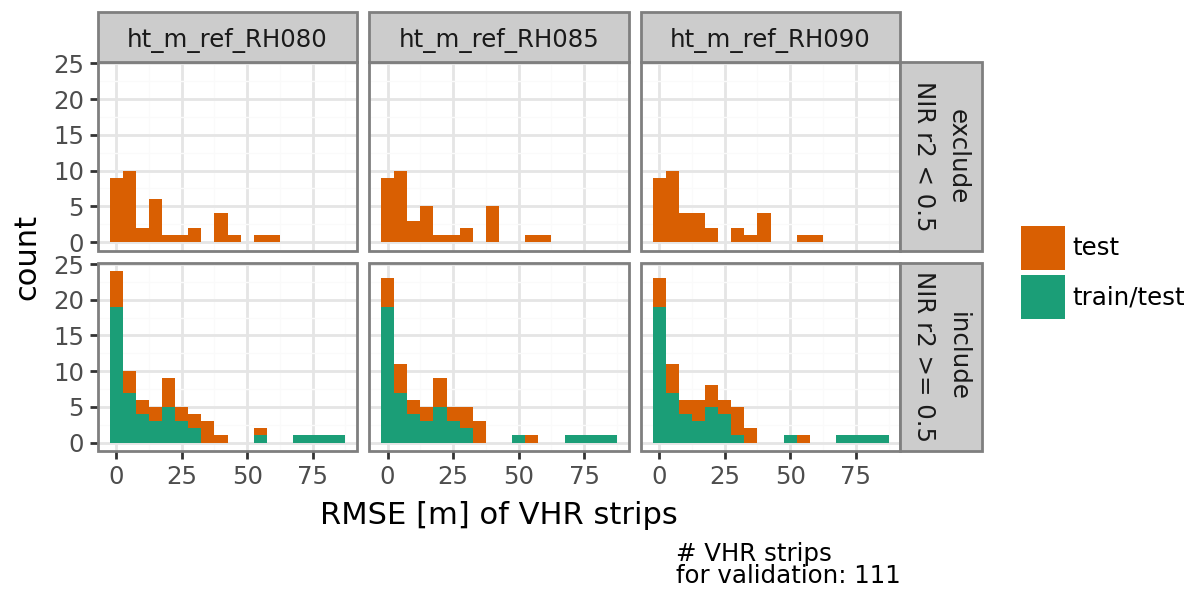

In [235]:
%%time

(
    ggplot(df_smry_footprint_updated, aes('rmse', fill='model_use_class')) 
    + geom_histogram(binwidth=5)
    + labs(x = 'RMSE [m] of VHR strips', caption=f"# VHR strips\nfor validation: {int(len(df_smry_footprint_updated)/len(LIST_REF_METRICS))}")
    + theme_bw()
    + scale_fill_brewer(type='qual', palette=2, direction=-1, name=' ')
    + facet_grid('srlite_metrics_class~ref_var')
    + theme(figure_size=(6, 3))
)

#### Summarize: 
Distribution of validation observations:  
 - footprints  
 - TCC intervals

In [236]:
%%time
df_smry_footprint_tcc = df_val.groupby(['footprint_name']).aggregate({'tcc_class':'first', 'footprint_name':'count'}).rename(columns={'footprint_name':'n_obs'})#.count().add_suffix('_count')
df_smry_footprint_tcc.reset_index(inplace=True)
df_smry_footprint_tcc['catid'] = df_smry_footprint_tcc['footprint_name'].str.split('-', expand=True)[0].str.split('_', expand=True)[3]


CPU times: user 5.82 s, sys: 244 ms, total: 6.06 s
Wall time: 12.2 s


CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 16 ms


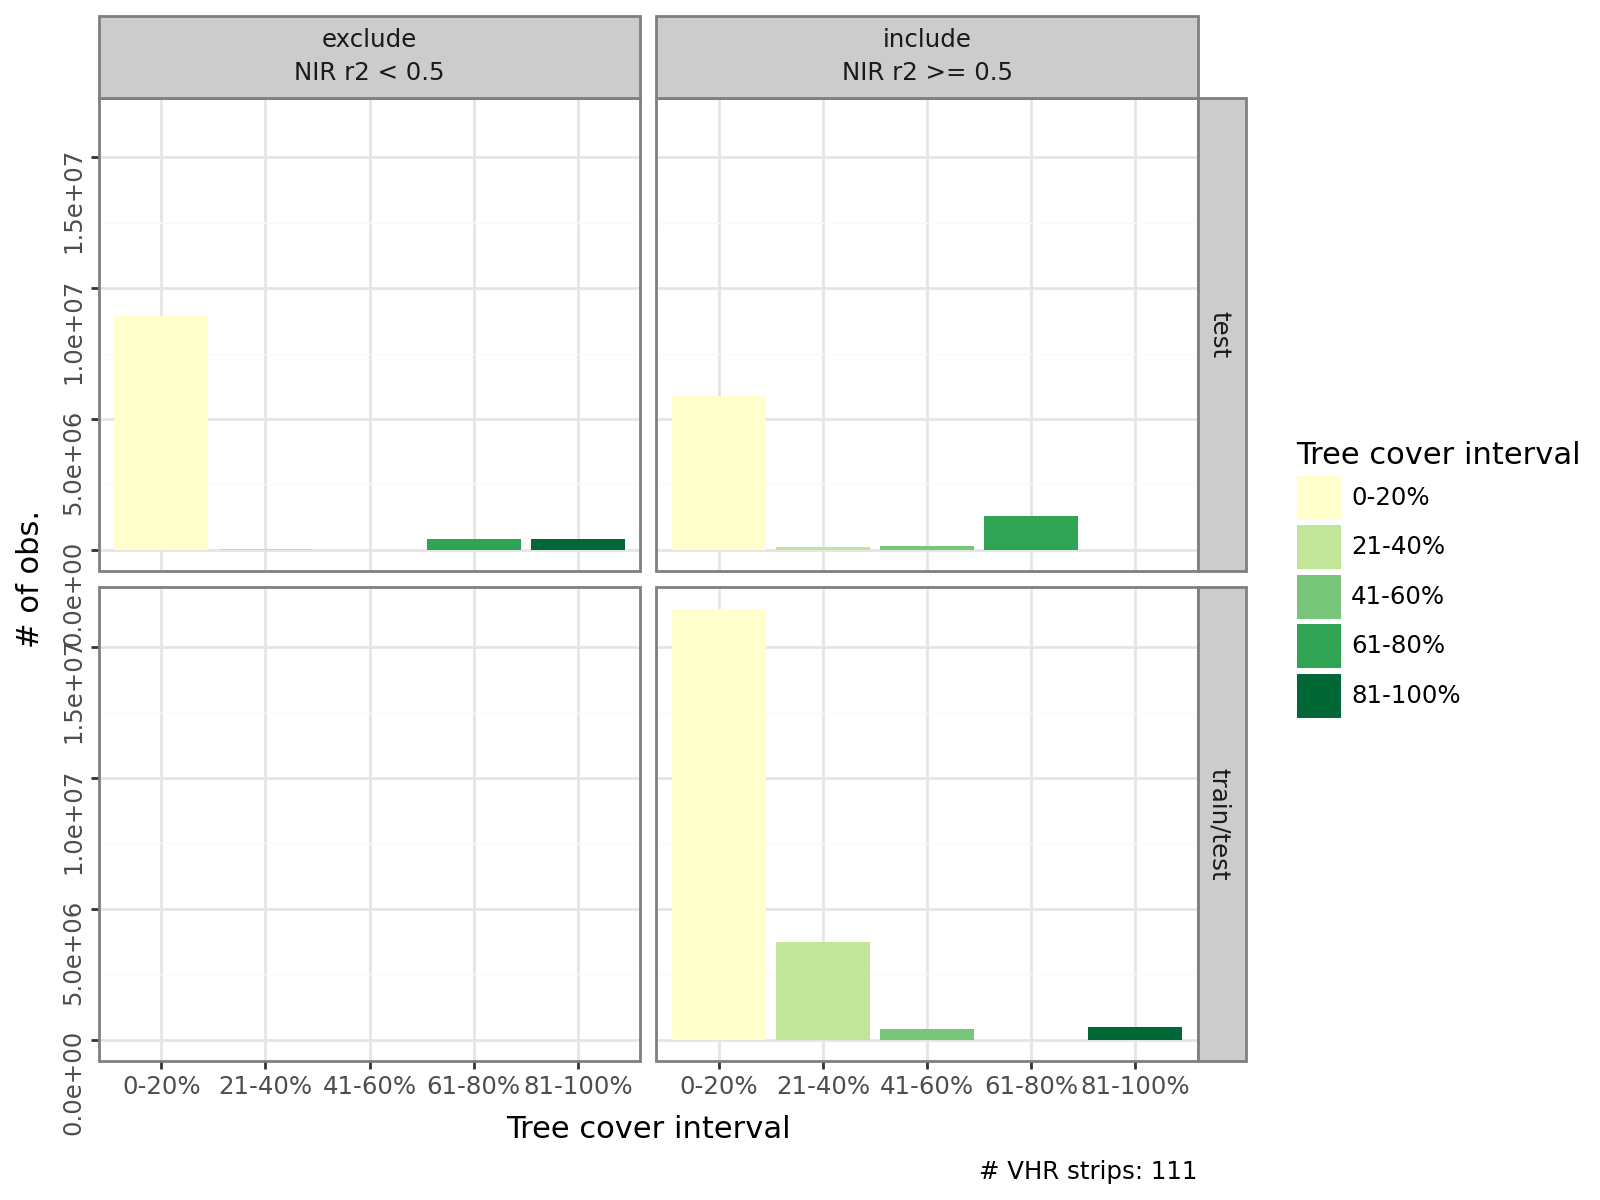

In [237]:
%%time

from mizani.formatters import scientific_format


df_smry_footprint_tcc['include_class'] = df_smry_footprint_tcc.apply(srlite_metrics_classifier, axis=1)
df_smry_footprint_tcc['model_use_class'] = df_smry_footprint_tcc.apply(model_use_classifier, axis=1)

(
    ggplot(df_smry_footprint_tcc, aes(x='tcc_class', y='n_obs', fill='tcc_class') )
    + geom_bar(stat = "identity")
    + geom_label(x=4, y=3e8, label=f'n = {df_val.shape[0]:,}', fill='white')
    + theme_bw()
    + scale_fill_brewer(type='seq', palette='YlGn'
                        #, guides=True
                        , name='Tree cover interval') 
    + scale_y_continuous(labels=scientific_format(digits=1))
    + theme(figure_size=(8, 6), axis_text_y = element_text(angle=90),axis_text_x = element_text(angle=0))
    + labs(x='Tree cover interval', y='# of obs.', caption=f"# VHR strips: {int(len(df_smry_footprint)/3)}")
    + facet_grid('model_use_class~include_class')
)

In [238]:
def plot_scatter_melt_3(df_val, sample_frac, LIST_REF_VARS, FACET_VAR_LIST='year', SCALE_FACTOR=None):
    
    if FACET_VAR_LIST is None:
        LIST_ID_VARS = []
    else:
        LIST_ID_VARS = FACET_VAR_LIST
    
#     # Get count of various groups
    df_smry_N_VHR_GROUP = df_val.groupby(['footprint_name']+FACET_VAR_LIST).aggregate(n_obs_footprint = ('footprint_name', 'count')).reset_index().groupby(FACET_VAR_LIST).aggregate(n_VHR = ('footprint_name', 'count')).reset_index()
    df_smry_N_VHR_GROUP['n_VHR_str'] = f"# VHR strips: " + df_smry_N_VHR_GROUP['n_VHR'].astype(str)
    N_VHR   = sum(df_smry_N_VHR_GROUP.n_VHR.to_list())
    
    df_smry_N_GROUPS = df_val.groupby(FACET_VAR_LIST).aggregate(n_obs_group=('type','count')).reset_index()
    df_smry_N_GROUPS['n_obs_group_str'] = "# obs: " + df_smry_N_GROUPS['n_obs_group'].astype(str)
    N_GROUPS = len(df_smry_N_GROUPS)
    
    # For fecetting nicely.
    if N_GROUPS == 3: N_GROUPS = 4
    
#     n_VHR_years = len(df_val.groupby(['year','footprint_name']).aggregate({'year':'count'}))
#     df_val.groupby(['year','footprint_name']).aggregate(n_obs_year_vhr = ('year','count')).reset_index()

    # Drop the ref vars you dont want
    LIST_REF_VARS_ALL = [x for x in df_val.columns.to_list() if "RH" in x]
    LIST_REF_VARS_RM = [var for var in LIST_REF_VARS_ALL if var not in LIST_REF_VARS]
    print(f'Cols to drop: {LIST_REF_VARS_RM}')
    df_val.drop(columns=LIST_REF_VARS_RM, inplace=True)
    
    # Change the names of the ref ht vars to make them look nicer
    LIST_REF_VARS = [x.split('_')[-1] for x in df_val.columns.to_list() if "RH" in x]
    print(LIST_REF_VARS)
    rename_dict = dict(zip([x for x in df_val.columns.to_list() if "RH" in x], LIST_REF_VARS))
    df_val.rename(rename_dict, axis=1, inplace=True)

    # Melt
    df_val_m = pd.melt(df_val[LIST_ID_VARS+LIST_REF_VARS+['ht_m_src'] ], id_vars=LIST_ID_VARS+['ht_m_src'] , value_vars=LIST_REF_VARS)
    if SCALE_FACTOR is not None:
        df_val_m['ht_m_src'] = df_val_m['ht_m_src'] * SCALE_FACTOR
        
    # Run the validation stats
    df_validation_smry_stats = round(df_val_m.groupby(LIST_ID_VARS+['variable']).apply(validation_smry_stats, 'value', 'ht_m_src').reset_index(), 2)
    df_validation_smry_stats['r2_value'] = round(df_validation_smry_stats['r_value'] * df_validation_smry_stats['r_value'], 2)
    df_validation_smry_stats['r2_value_str'] = f"$r^2$: " + df_validation_smry_stats['r2_value'].astype(str)
    df_validation_smry_stats['rmse_str'] = f"rmse [m]: " + df_validation_smry_stats['rmse'].astype(str)
    df_validation_smry_stats['mae_str'] = f"mae [m]: " + df_validation_smry_stats['mae'].astype(str)
    df_validation_smry_stats['bias_str'] = f"bias [m]: " + df_validation_smry_stats['intercept'].astype(str)
    df_validation_smry_stats['variable'] = df_validation_smry_stats['variable'].apply(lambda x: x.split('_')[-1])
    #print(df_val_m.head())
    max_val = 30
    #fig, p = (
    p = (ggplot(
            df_val_m.sample(frac=sample_frac),
            aes(x='value', y='ht_m_src')#, group='variable')
    )
    + labs(title='', x="Reference Canopy Height [m]", y='Predicted Canopy Height [m]')
    + geom_bin2d(binwidth=0.25)
    + geom_abline(linetype='dashed')
    + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top')
    + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-4, label='rmse_str'), ha='left', va='top')
    + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-8, label='mae_str'), ha='left', va='top')
    + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-12, label='bias_str'), ha='left', va='top')
    + geom_label(data=df_smry_N_GROUPS, mapping=aes(x=15, y=max_val, label='n_obs_group_str'), ha='left', va='top')
    + geom_label(data=df_smry_N_VHR_GROUP, mapping=aes( x=15, y=max_val-4, label='n_VHR_str'), ha='left', va='top')
    # + annotate(geom='label', x=20, y=max_val-4, label=f"# VHR strips: {n_VHR}", ha='left', va='top')
    + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
    + scale_fill_cmap(cmap_name='plasma', trans='log10', name='# obs.')
    
    #+ facet_grid(f'. ~ {FACET_VAR}')
    + facet_grid(f'{FACET_VAR_LIST[0]} ~ {FACET_VAR_LIST[1]}')
    + theme_bw()
    + theme(figure_size=(2 + N_GROUPS*2, N_GROUPS*2), strip_text = element_text(size=9))
    + labs(caption=f'{os.path.basename(dir_val_csv)}')
    )#.draw(show=True) #, return_ggplot=True)
    

    if sample_frac < 1:
        #fig, p = (
        p = (
                p + annotate(geom='label', x=20, y=5, label=f'plotting {sample_frac*100}% of data', size=6, ha='left', va='top')          
        )#.draw(show=True) #, return_ggplot=True)

    fig = p.draw(show=True)

    # if FACET_VAR is not None:
    #     p = ( p + facet_wrap(f"~{FACET_VAR}",ncol=N_YEARS) )
    print(p)
    METRICS_STR = '_'.join([n.split('_')[-1] for n in LIST_REF_VARS])
    out_plot_fn = os.path.join(dir_val_plots, f"plot_scatter_{'_'.join(FACET_VAR_LIST)}_nVHR{N_VHR:04}_{METRICS_STR}.png")
    fig.savefig(out_plot_fn, dpi=300)
    print(f'Saved {out_plot_fn}')
    return df_validation_smry_stats
    #return df_smry_N_VHR_GROUP

In [240]:
g = df_val.groupby('model_use_class')
g.groups.keys()

dict_keys(['test', 'train/test'])

/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel-current/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 20'. Pick better value with 'binwidth'.


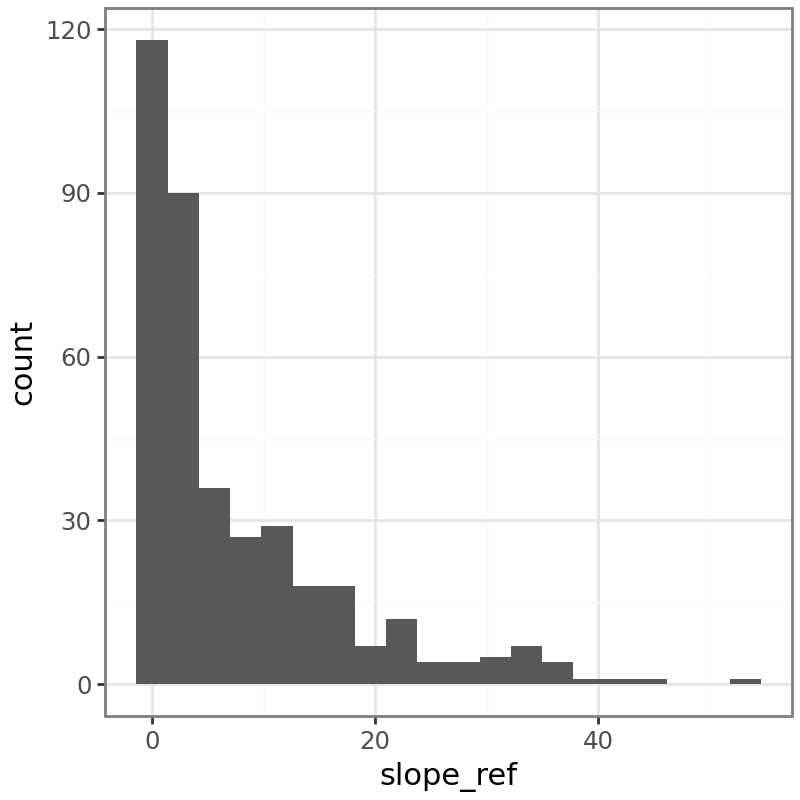

In [241]:
# What are the slopes?
(
    ggplot( df_val.sample(frac=0.00001)) 
    + geom_histogram(aes(x='slope_ref'))
    + theme_bw()
    + theme(figure_size=(4,4), strip_text = element_text(size=9)) 
)

#### Current plot

Cols to drop: ['ht_m_ref_RH085', 'ht_m_ref_RH090']
['RH080']


/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_3814531/3026593394.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


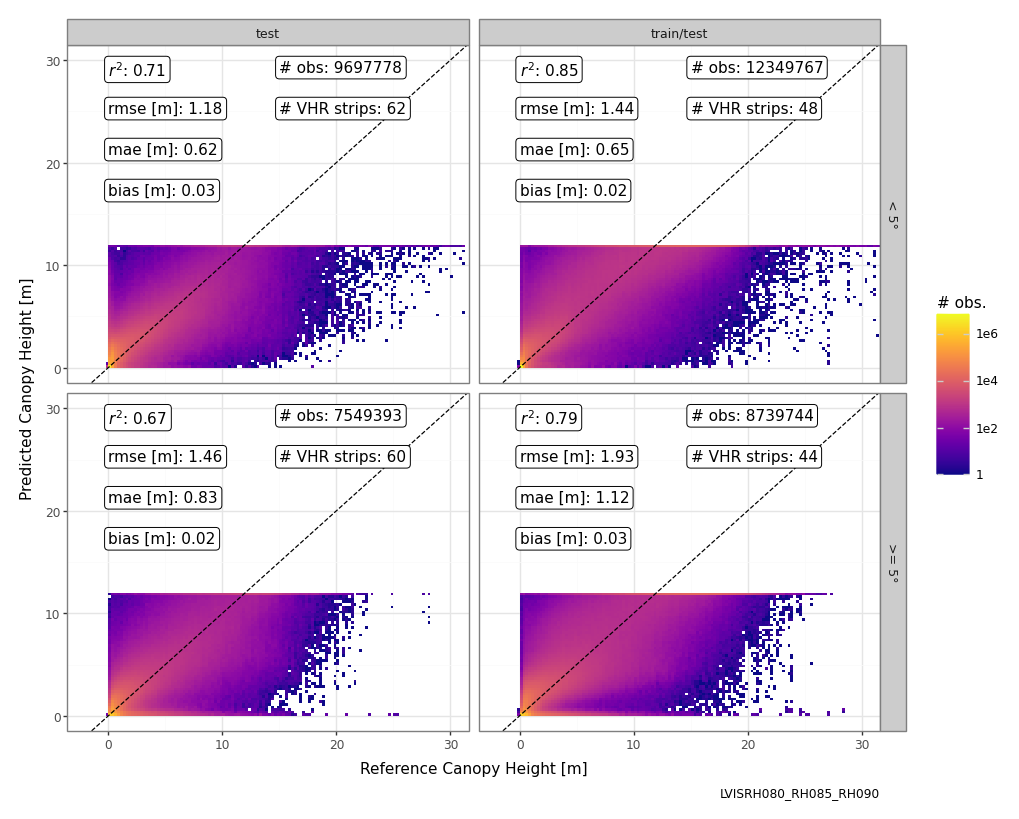

<ggplot: (1000 x 800)>
Saved /explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/plots/plot_scatter_slope_class_model_use_class_nVHR0214_RH080.png
CPU times: user 5min 12s, sys: 25.1 s, total: 5min 38s
Wall time: 6min 14s


In [242]:
%%time

df_validation_smry_stats = plot_scatter_melt_3(df_val.sample(frac=1), 1, LIST_REF_METRICS[0:1], FACET_VAR_LIST=['slope_class','model_use_class'], SCALE_FACTOR=0.1)

#### Old plot

Cols to drop: ['ht_m_ref_RH085', 'ht_m_ref_RH090']
['RH080']


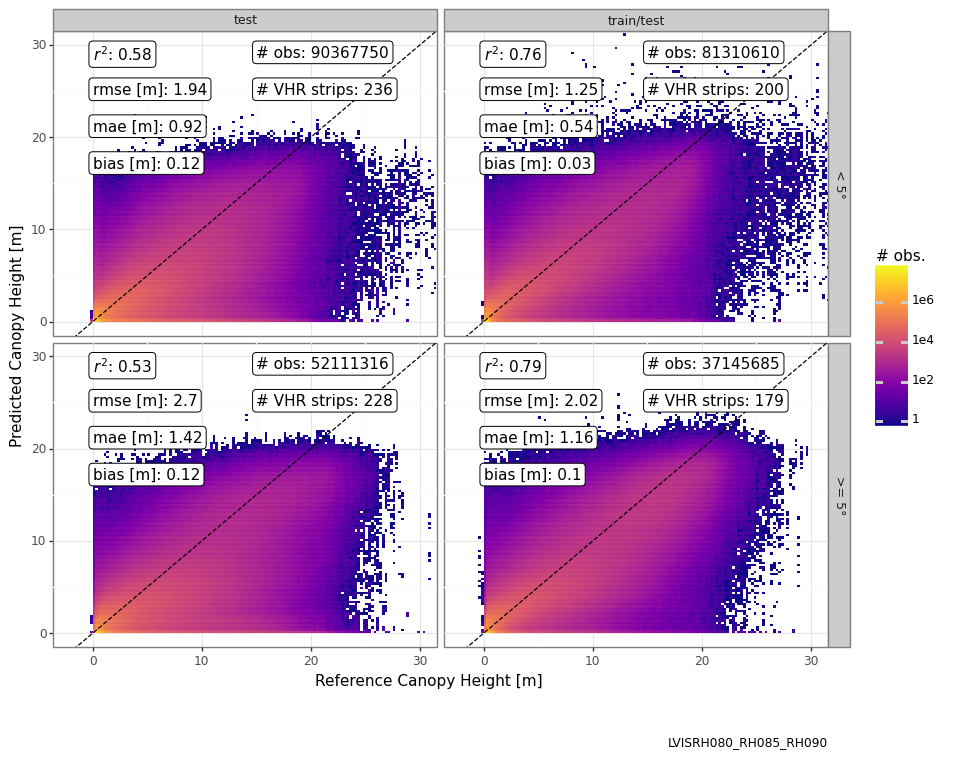


Saved /explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/plots/plot_scatter_slope_class_model_use_class_nVHR0843_RH080.png
CPU times: user 1h 1min 16s, sys: 9min 19s, total: 1h 10min 35s
Wall time: 1h 10min 25s


,slope_class,model_use_class,variable,n,slope,intercept,r_value,p_value,std_err,ref_var,...,expvarscore,mae,mse,rmse,medae,r2_value,r2_value_str,rmse_str,mae_str,bias_str
0,< 5°,test,RH080,90367750,0.56,0.12,0.76,0.0,0.0,value,...,0.58,0.92,3.75,1.94,0.27,0.58,$r^2$: 0.58,rmse [m]: 1.94,mae [m]: 0.92,bias [m]: 0.12
1,< 5°,train/test,RH080,81310610,0.76,0.03,0.87,0.0,0.0,value,...,0.76,0.54,1.56,1.25,0.18,0.76,$r^2$: 0.76,rmse [m]: 1.25,mae [m]: 0.54,bias [m]: 0.03
2,>= 5°,test,RH080,52111316,0.52,0.12,0.73,0.0,0.0,value,...,0.54,1.42,7.28,2.70,0.53,0.53,$r^2$: 0.53,rmse [m]: 2.7,mae [m]: 1.42,bias [m]: 0.12
3,>= 5°,train/test,RH080,37145685,0.79,0.10,0.89,0.0,0.0,value,...,0.79,1.16,4.07,2.02,0.53,0.79,$r^2$: 0.79,rmse [m]: 2.02,mae [m]: 1.16,bias [m]: 0.1


In [50]:
%%time

df_validation_smry_stats = plot_scatter_melt_3(df_val.sample(frac=1), 1, LIST_REF_METRICS[0:1], FACET_VAR_LIST=['slope_class','model_use_class'])
df_validation_smry_stats.head()

Cols to drop: ['ht_m_ref_RH085', 'ht_m_ref_RH090']
['RH080']


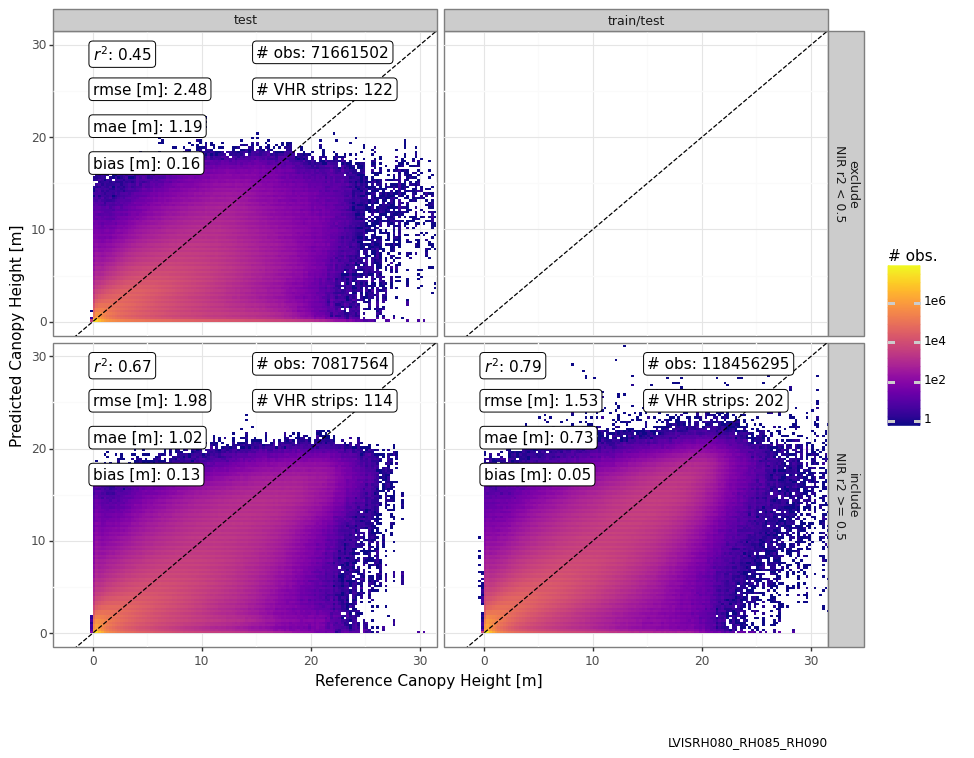


Saved /explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/plots/plot_scatter_srlite_class_model_use_class_nVHR0438_RH080.png
CPU times: user 1h 2min 54s, sys: 9min 32s, total: 1h 12min 27s
Wall time: 1h 12min 22s


,srlite_class,model_use_class,variable,n,slope,intercept,r_value,p_value,std_err,ref_var,...,expvarscore,mae,mse,rmse,medae,r2_value,r2_value_str,rmse_str,mae_str,bias_str
0,exclude\nNIR r2 < 0.5,test,RH080,71661502,0.41,0.16,0.67,0.0,0.0,value,...,0.44,1.19,6.17,2.48,0.32,0.45,$r^2$: 0.45,rmse [m]: 2.48,mae [m]: 1.19,bias [m]: 0.16
1,include\nNIR r2 >= 0.5,test,RH080,70817564,0.65,0.13,0.82,0.0,0.0,value,...,0.67,1.02,3.90,1.98,0.38,0.67,$r^2$: 0.67,rmse [m]: 1.98,mae [m]: 1.02,bias [m]: 0.13
2,include\nNIR r2 >= 0.5,train/test,RH080,118456295,0.78,0.05,0.89,0.0,0.0,value,...,0.79,0.73,2.34,1.53,0.27,0.79,$r^2$: 0.79,rmse [m]: 1.53,mae [m]: 0.73,bias [m]: 0.05


In [51]:
%%time

df_validation_smry_stats = plot_scatter_melt_3(df_val.sample(frac=1), 1, LIST_REF_METRICS[0:1], FACET_VAR_LIST=['srlite_class','model_use_class'])
df_validation_smry_stats.head()

## Summarize and Plot validation obs 
#### across LVIS RH metrics

Cols to drop: ['ht_m_ref_RH085', 'ht_m_ref_RH090']
['RH080']


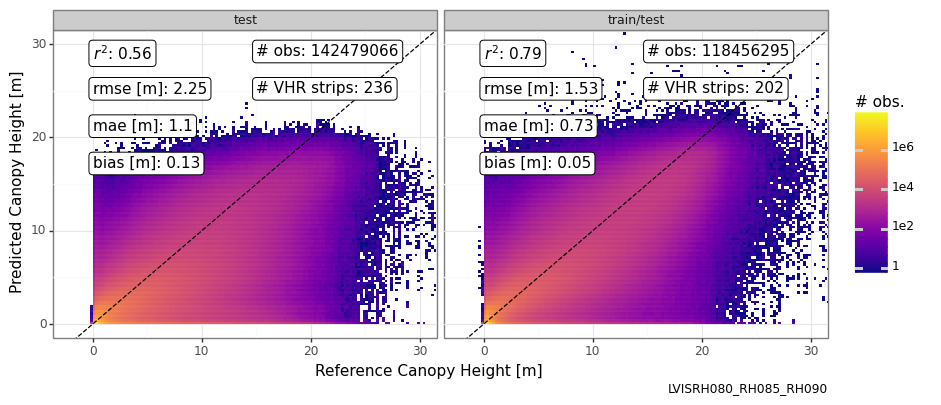


Saved /explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/plots/plot_scatter_model_use_class_nVHR0438_RH080.png
CPU times: user 30min 34s, sys: 5min 24s, total: 35min 58s
Wall time: 35min 52s


,model_use_class,variable,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,mae,mse,rmse,medae,r2_value,r2_value_str,rmse_str,mae_str,bias_str
0,test,RH080,142479066,0.54,0.13,0.75,0.0,0.0,value,0.50,0.56,1.10,5.04,2.25,0.35,0.56,$r^2$: 0.56,rmse [m]: 2.25,mae [m]: 1.1,bias [m]: 0.13
1,train/test,RH080,118456295,0.78,0.05,0.89,0.0,0.0,value,0.78,0.79,0.73,2.34,1.53,0.27,0.79,$r^2$: 0.79,rmse [m]: 1.53,mae [m]: 0.73,bias [m]: 0.05


In [52]:
%%time

df_validation_smry_stats = plot_scatter_melt_2(df_val.sample(frac=1), 1, LIST_REF_METRICS[0:1], FACET_VAR='model_use_class')
df_validation_smry_stats.head()

In [47]:
df_val.head()

,ht_m_src,ht_m_ref_RH080,ht_m_ref_RH085,ht_m_ref_RH090,tcc_ref,slope_ref,cnt_ref,tcc_class,file,date,type,footprint_name,catid,sensor,year,month,slope_class,srlite_class,model_use_class
0,2.8,9.073636,9.602727,10.714545,5608.0,0.182577,11.0,41-60%,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,2019-07-23,CHM pred,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,10400100506ED100,WV03,2019,7,< 5°,include\nNIR r2 >= 0.5,train
1,2.4,9.073636,9.602727,10.714545,5608.0,0.182577,11.0,41-60%,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,2019-07-23,CHM pred,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,10400100506ED100,WV03,2019,7,< 5°,include\nNIR r2 >= 0.5,train
2,0.4,12.725294,13.531177,14.698236,6653.0,0.524835,17.0,61-80%,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,2019-07-23,CHM pred,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,10400100506ED100,WV03,2019,7,< 5°,include\nNIR r2 >= 0.5,train
3,0.6,12.725294,13.531177,14.698236,6653.0,0.524835,17.0,61-80%,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,2019-07-23,CHM pred,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,10400100506ED100,WV03,2019,7,< 5°,include\nNIR r2 >= 0.5,train
4,6.4,3.348182,3.768182,4.291818,4210.0,0.508962,11.0,41-60%,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,2019-07-23,CHM pred,WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...,10400100506ED100,WV03,2019,7,< 5°,include\nNIR r2 >= 0.5,train


#### across LVIS RH metrics and years

In [53]:
%%time

df_validation_smry_stats_YEAR = plot_scatter_melt_2(df_val.sample(frac=1), 1, LIST_REF_METRICS, FACET_VAR='year')
df_validation_smry_stats_YEAR


KeyboardInterrupt



#### Summarize: Distribution of validation observations across LVIS RH metrics
--- replaced above---

In [55]:
# %%time
# def do_val_smry(REF_VAR):
#     return df_val.groupby(['type']).apply(validation_smry_stats, REF_VAR, 'ht_m_src').reset_index()
    
# if True:
#     with Pool(processes=3) as pool:
#         df_val_smry_list = pool.map(partial(do_val_smry), ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] )
# else:
#     df_val_smry_list = [df_val.groupby(['type']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]
    
# df_val_smry_RHmetric = pd.concat(df_val_smry_list)
# df_val_smry_RHmetric

### Plot overall
--- replaced above---

In [ ]:
%%time
if True:
    with Pool(processes=3) as pool:
        p_list = pool.map(partial(plot_scatter, df_val, 1, df_val_smry_RHmetric), ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] )
else:
    [plot_scatter(df_val, 1, df_val_smry_RHmetric, x_var) for x_var in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]

In [357]:
print(f'Validation data frame has {df_val.shape[0]/1e9:,} billion observations of 10 m pred. vs obs. canopy height estimates across Alaska')

Validation data frame has 0.260935361 billion observations of 10 m pred. vs obs. canopy height estimates across Alaska


#### Summarize: Distribution of validation observations across LVIS RH metrics  
 - year

In [243]:
%%time

df_smry_year_list = [df_val.sample(frac=1).groupby(['year']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]
df_smry_year = pd.concat(df_smry_year_list).round(3)
df_smry_year.head(10)

CPU times: user 5.97 s, sys: 11.3 ms, total: 5.98 s
Wall time: 6 s


,year,n,slope,intercept,r_value,p_value,std_err,ref_var,r2score,expvarscore,mae,mse,rmse,medae
0,2012,140648,1.052,0.271,0.697,0.0,0.003,ht_m_ref_RH050,-0.964,-0.174,0.270,0.169,0.411,0.230
1,2013,611962,0.803,0.515,0.767,0.0,0.001,ht_m_ref_RH050,0.435,0.511,0.629,1.206,1.098,0.203
2,2014,393848,0.779,0.562,0.567,0.0,0.002,ht_m_ref_RH050,-0.586,-0.327,0.718,1.457,1.207,0.300
3,2015,116056,0.118,0.036,0.019,0.0,0.018,ht_m_ref_RH050,-84.634,-36.790,0.142,0.036,0.190,0.120
4,2016,858571,0.214,0.269,0.362,0.0,0.001,ht_m_ref_RH050,0.077,0.079,0.795,3.956,1.989,0.217
5,2017,32765,3.693,0.885,0.587,0.0,0.028,ht_m_ref_RH050,-97.827,-32.180,0.346,0.181,0.425,0.234
6,2019,640004,1.042,1.136,0.911,0.0,0.001,ht_m_ref_RH050,0.697,0.776,1.503,5.709,2.389,0.740
0,2012,140648,0.614,-0.050,0.821,0.0,0.001,ht_m_ref_RH075,0.627,0.669,0.148,0.131,0.361,0.101
1,2013,611962,0.645,0.091,0.831,0.0,0.001,ht_m_ref_RH075,0.648,0.687,0.678,1.365,1.169,0.285
2,2014,393848,0.576,0.114,0.687,0.0,0.001,ht_m_ref_RH075,0.381,0.449,0.699,1.524,1.234,0.274


### Plot stats summary results by LVIS RH

In [244]:
df_smry_year_m = pd.melt(df_smry_year, id_vars=['year', 'ref_var'] , value_vars=['r2score','expvarscore','mae','mse','rmse','medae'])
df_smry_year_m

,year,ref_var,variable,value
0,2012,ht_m_ref_RH050,r2score,-0.964
1,2013,ht_m_ref_RH050,r2score,0.435
2,2014,ht_m_ref_RH050,r2score,-0.586
3,2015,ht_m_ref_RH050,r2score,-84.634
4,2016,ht_m_ref_RH050,r2score,0.077
...,...,...,...,...
121,2014,ht_m_ref_RH098,medae,1.955
122,2015,ht_m_ref_RH098,medae,0.847
123,2016,ht_m_ref_RH098,medae,0.855
124,2017,ht_m_ref_RH098,medae,1.250


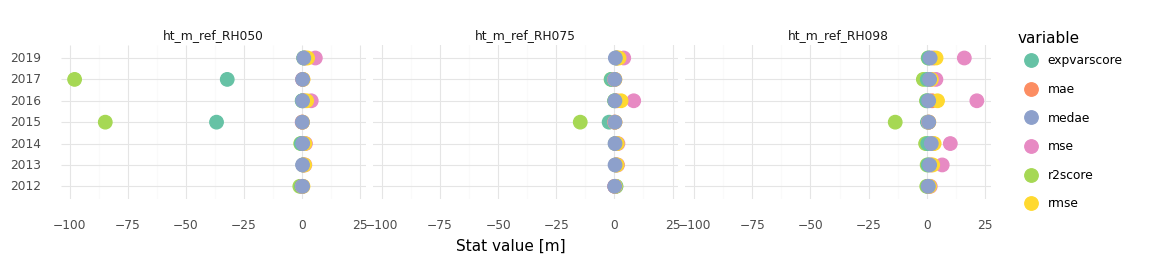

<ggplot: (1437480987405)>

In [249]:
( 
    ggplot(df_smry_year_m, aes(x='value', y='factor(year)', color='variable'))
        + geom_point(size=5)
    + scale_color_brewer(type='qual', palette=7)
    + labs(y = None, x = 'Stat value [m]')
    + facet_grid('~ ref_var')
    + theme_minimal()
    + theme(figure_size = (12,2))

)


# Use vhr metadata to examine predictions = 0  
 - do these 0 vals come from only a few strips?  
 - is there a link to sub-optimal SSG?